In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.transform import rescale

from sladsnet.input_params import ERDInputParams, GeneralInputParams, SampleParams
from sladsnet.code.measurement_interface import TransmissionSimulationMeasurementInterface, ExperimentMeasurementInterface
from sladsnet.code.erd import SladsSklearnModel
from sladsnet.code.results import Result
from sladsnet.code.base import ExperimentalSample, Sample
from sladsnet.code.sampling import run_sampling
from sladsnet.code.utils import renormalize
from sladsnet.utils.readMDA import readMDA

In [4]:
from skimage.metrics import structural_similarity, mean_squared_error

In [5]:
cm = mpl.cm.viridis.copy()
#cm.set_bad('black')
cnorm = mpl.colors.LogNorm

In [6]:
def clean_and_normalize(x):
    x = np.nan_to_num(x, nan=0, posinf=0, neginf=0)
    x = (x - x.min()) / (x.max() - x.min())
    return x
    

In [7]:
C_VALUE = 2
train_base_path = Path.cwd().parent.parent / 'ResultsAndData/TrainingData/cameraman/'
erd_model = SladsSklearnModel(load_path=train_base_path / f'c_{C_VALUE}/erd_model_relu.pkl')

In [12]:
mda = readMDA('26idbSOFT_0129.mda')

26idbSOFT_0129.mda is a 2-D file; 2 dimensions read in.
dim[0] = dictionary of 8 scan-environment PVs
   usage: dim[0]['sampleEntry'] -> ('description', 'unit string', 'value')
dim[1] = 1D data from "26idbSOFT:scan2": 81/81 pts; 1 pos's, 0 dets, 2 trigs
dim[2] = 2D data from "26idbSOFT:scan1": 401/401 pts; 1 pos's, 70 dets, 3 trigs
   usage: dim[1].p[2].data -> 1D array of positioner 2 data
   usage: dim[2].d[7].data -> 2D array of detector 7 data


## Running for mda[2].d[3]

In [192]:
int1 = np.array(mda[2].d[3].data)

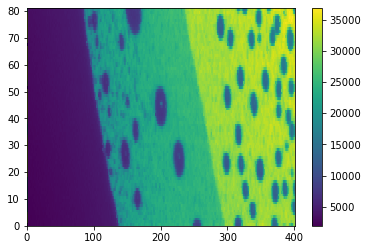

In [193]:
plt.pcolormesh(mda[2].d[3].data)
plt.colorbar()

In [194]:
normalized_int = renormalize(int1)

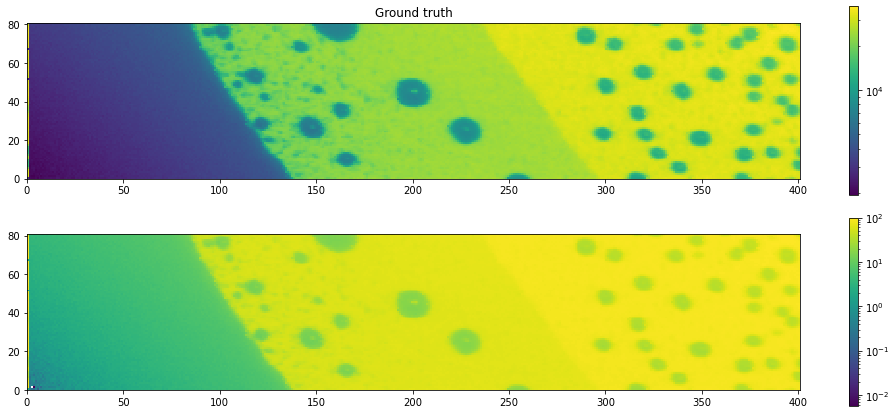

In [195]:
fig, axs = plt.subplots(2, 1, figsize=[14,6])
plt.subplot(2,1,1)
plt.pcolormesh(int1, cmap=cm, norm=cnorm())
plt.gca().set_aspect('equal')
plt.title('Ground truth')
plt.colorbar()
plt.subplot(2,1,2)
plt.pcolormesh(normalized_int, cmap=cm, norm=cnorm())
plt.gca().set_aspect('equal')
plt.colorbar()
plt.tight_layout()


In [237]:
inner_batch_size = 100
initial_scan_points_num = 500

stop_ratio = 0.9
store_results_percentage = 1

affected_neighbors_window_min = 5
affected_neighbors_window_max = 15
full_erd_recalculation_frequency = 1

In [238]:
params_erd = ERDInputParams(c_value=C_VALUE,
                            full_erd_recalculation_frequency=full_erd_recalculation_frequency,
                            affected_neighbors_window_min=affected_neighbors_window_min,
                            affected_neighbors_window_max=affected_neighbors_window_max)
params_gen = GeneralInputParams()

sample_params = SampleParams(image_shape=normalized_int.shape,
                             inner_batch_size=inner_batch_size,
                             initial_scan_points_num=initial_scan_points_num,
                             initial_scan_ratio=None,
                             stop_ratio=stop_ratio,
                             random_seed=11)


#measurement_interface = ExperimentMeasurementInterface()#'instructions.csv', num_initial_idxs= 2000)
#interface.perform_measurement(sample_params.initial_idxs)
measurement_interface = TransmissionSimulationMeasurementInterface(image=normalized_int)

In [239]:
sample = Sample(sample_params=sample_params,
                general_params=params_gen,
                erd_params=params_erd,
                measurement_interface=measurement_interface,
                erd_model=erd_model)
results = Result()

In [240]:
run_sampling(sample, results=results, results_frequency_step=1, results_frequency_percentage=0, 
             disable_progress_bar=False, debug=False, indices_to_actually_measure=50)

No more improvements expected. Stopping scan.


(<sladsnet.code.results.Result at 0x17a172740>, 396)

In [241]:
erds = results.outputs.erds
total_erds = np.sum(erds, axis=(1,2))

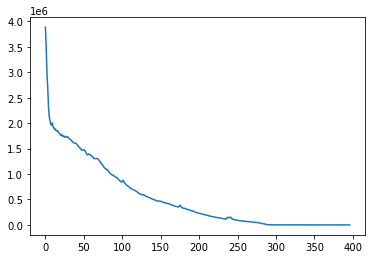

In [242]:
plt.plot(total_erds)

In [243]:
total_erds

array([3.88453575e+06, 3.49271075e+06, 2.99899200e+06, 2.69628650e+06,
       2.32707475e+06, 2.12637225e+06, 2.04318650e+06, 1.97260800e+06,
       1.96210688e+06, 2.00514250e+06, 1.92662650e+06, 1.91229225e+06,
       1.87373512e+06, 1.88323875e+06, 1.85144050e+06, 1.84729238e+06,
       1.85073488e+06, 1.81100012e+06, 1.79997488e+06, 1.78897362e+06,
       1.75497075e+06, 1.76996725e+06, 1.75999088e+06, 1.73658600e+06,
       1.74698600e+06, 1.72287500e+06, 1.73889450e+06, 1.72943300e+06,
       1.72731988e+06, 1.73249638e+06, 1.70922450e+06, 1.69517138e+06,
       1.68453812e+06, 1.66876362e+06, 1.65411300e+06, 1.64496200e+06,
       1.62241425e+06, 1.61252175e+06, 1.60651512e+06, 1.60706912e+06,
       1.60039450e+06, 1.58035812e+06, 1.56674425e+06, 1.54194450e+06,
       1.52391025e+06, 1.50841350e+06, 1.50340538e+06, 1.46857412e+06,
       1.47072175e+06, 1.47156225e+06, 1.47807200e+06, 1.46485588e+06,
       1.44969625e+06, 1.40947050e+06, 1.38471738e+06, 1.37527125e+06,
      

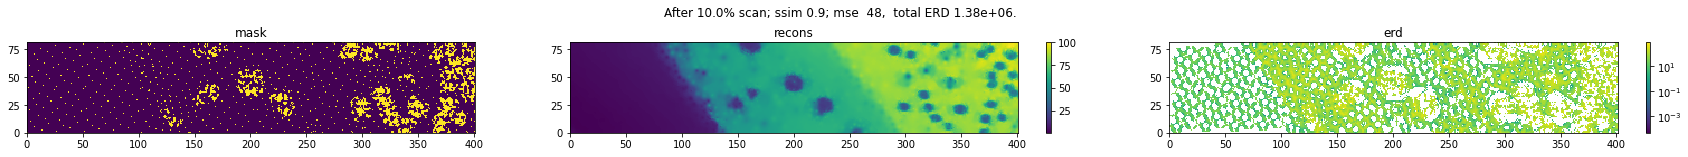

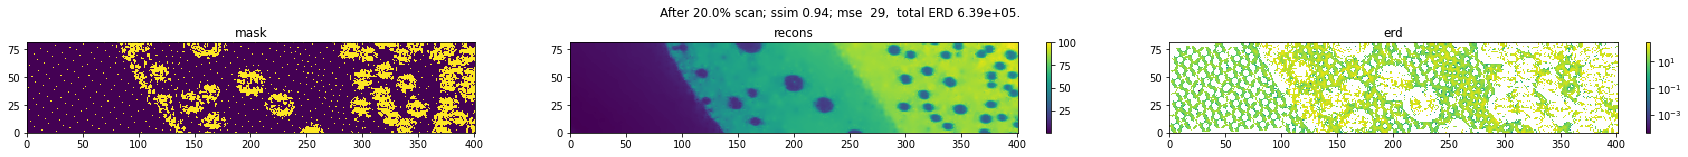

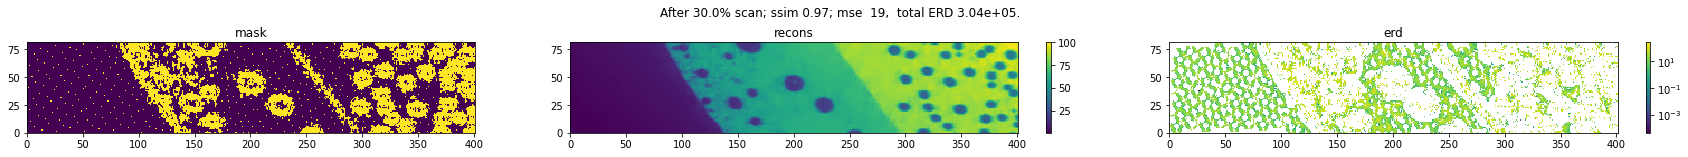

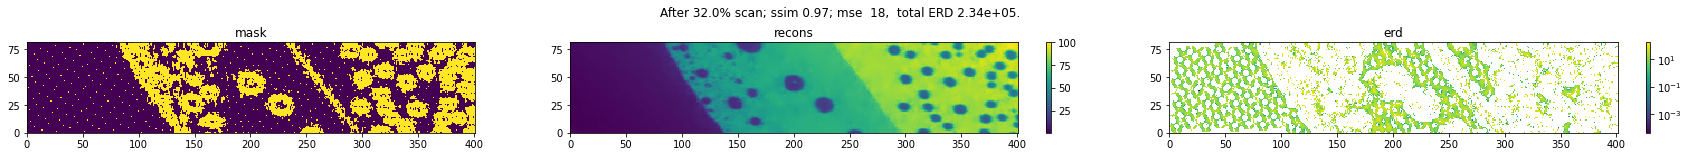

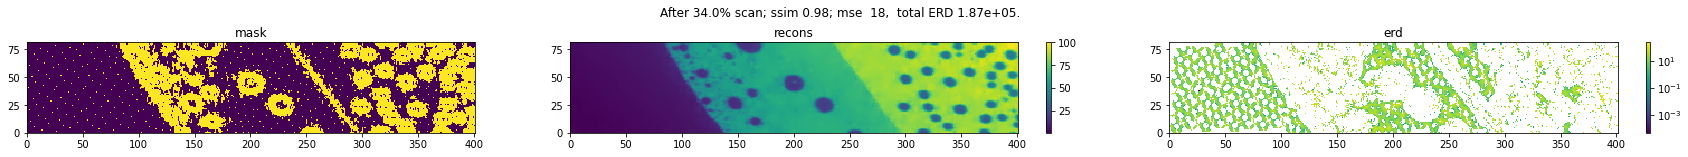

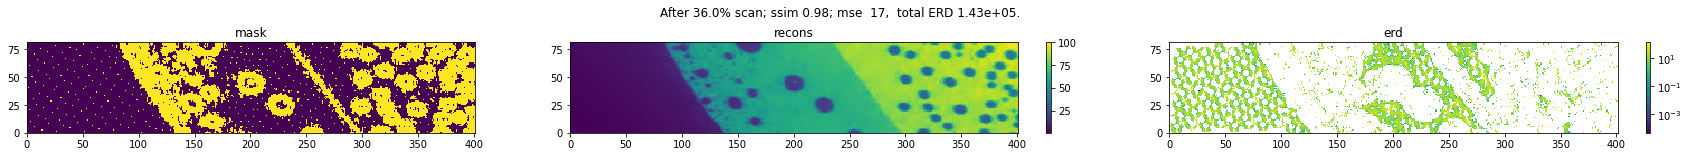

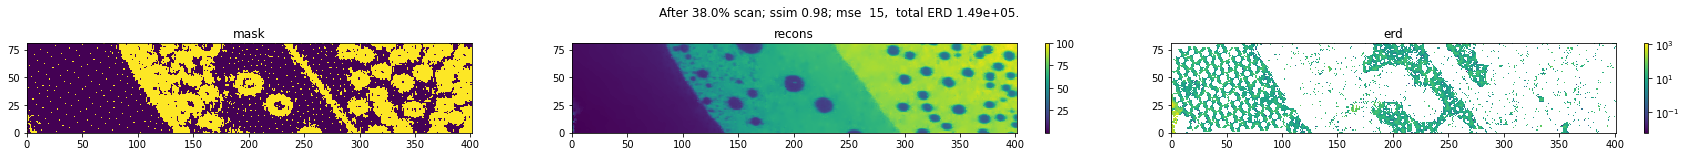

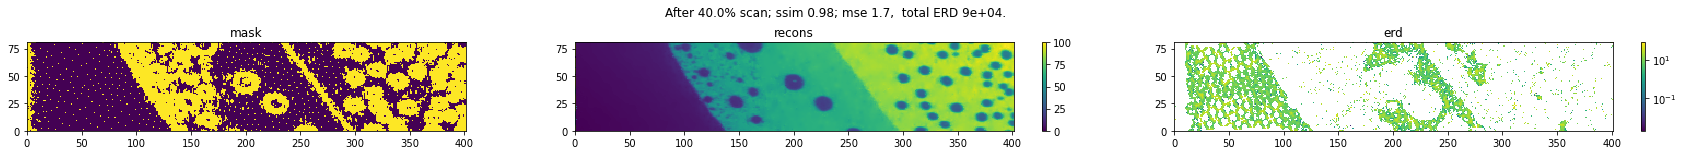

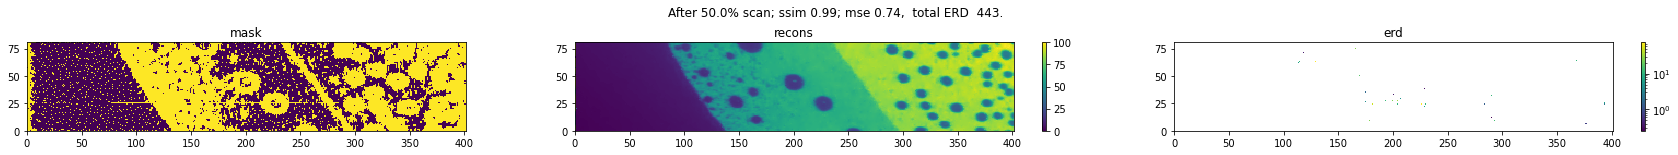

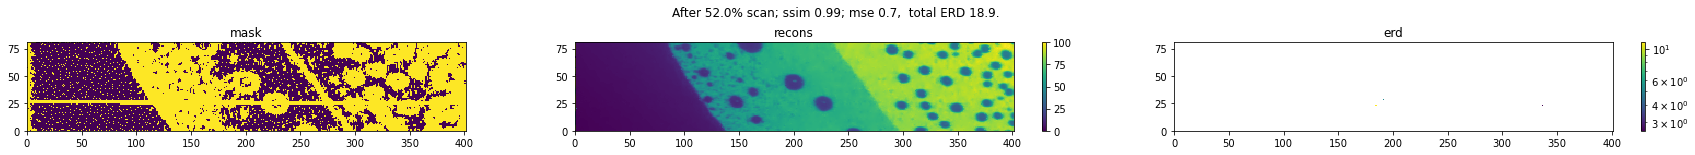

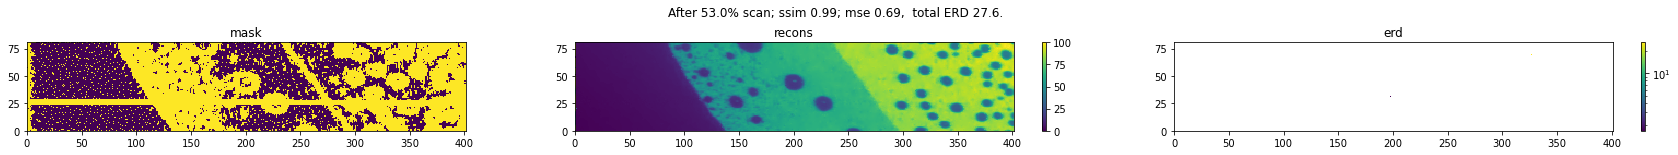

In [253]:
for i in range(results.size):
    #scan_ratio = (i + 1) * 0.1
    #percent = int(scan_ratio * 100)
    
    #if percent >= results.size:
    #    percent = results.size - 1
    
    actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 1)
    #percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
    percent = actual_percent
    if percent not in [10, 20, 30, 32, 34, 36, 37, 38, 39, 40, 50, 52, 53]: continue
    
    
    fig, axs = plt.subplots(1, 3, figsize=[25, 2])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[i])
    plt.gca().set_aspect('equal')
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[i], cmap=cm)
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    #err = measurement_interface.image - results.outputs.recons[i]
    plt.pcolormesh(results.outputs.erds[i], cmap=cm, norm=cnorm())#measurement_interface.image - results.outputs.recons[i])
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('erd')
    
    ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
    erd_this = results.outputs.erds[i].sum()
    
    plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
                 f' total ERD {erd_this:4.3g}.')
    plt.tight_layout()
    plt.show()


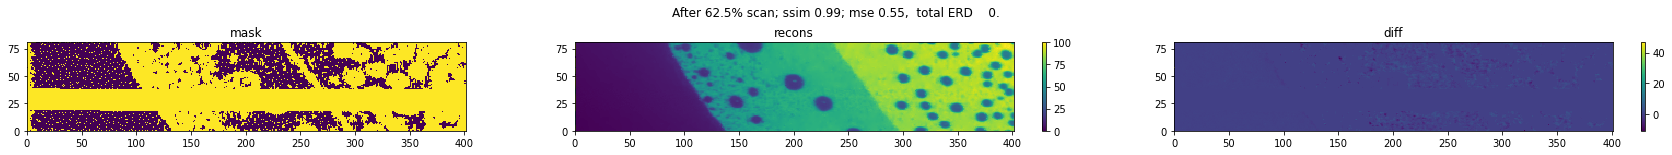

In [226]:
for i in range(results.size):
    #scan_ratio = (i + 1) * 0.1
    #percent = int(scan_ratio * 100)
    
    #if percent >= results.size:
    #    percent = results.size - 1
    
    actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 1)
    #percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
    percent = actual_percent
    if percent not in [51]: continue
    
    
    fig, axs = plt.subplots(1, 3, figsize=[25, 2])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[i])
    plt.gca().set_aspect('equal')
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[i], cmap=cm)
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    err = measurement_interface.image - results.outputs.recons[i]
    plt.pcolormesh(measurement_interface.image - results.outputs.recons[i])
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('diff')
    
    ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
    erd_this = results.outputs.erds[i].sum()
    
    plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
                 f' total ERD {erd_this:4.3g}.')
    plt.tight_layout()
    plt.show()


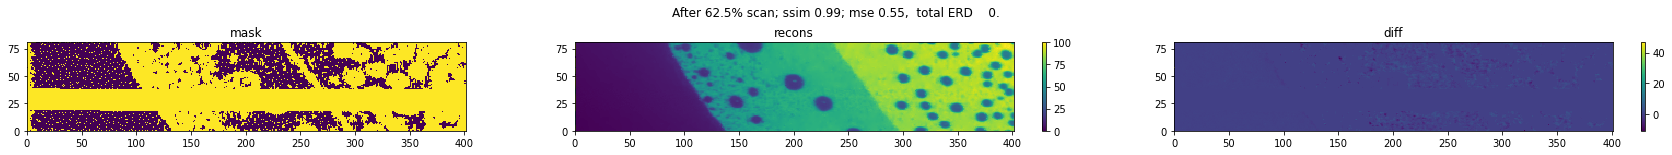

In [245]:
i = -1
actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 1)
#percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
percent = actual_percent
#if percent not in [10, 20, 30]: continue


fig, axs = plt.subplots(1, 3, figsize=[25, 2])
plt.subplot(1, 3, 1)
plt.pcolormesh(results.outputs.masks[i])
plt.gca().set_aspect('equal')
plt.title('mask')
plt.subplot(1, 3, 2)
plt.pcolormesh(results.outputs.recons[i], cmap=cm)
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('recons')
plt.subplot(1, 3, 3)
err = measurement_interface.image - results.outputs.recons[i]
plt.pcolormesh(measurement_interface.image - results.outputs.recons[i])
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('diff')

ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                             data_range=255)
mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
erd_this = results.outputs.erds[i].sum()

plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
             f' total ERD {erd_this:4.3g}.')
plt.tight_layout()
plt.show()

### Running the scan on the log 

In [254]:

log_int = renormalize(clean_and_normalize(np.log(int1)))

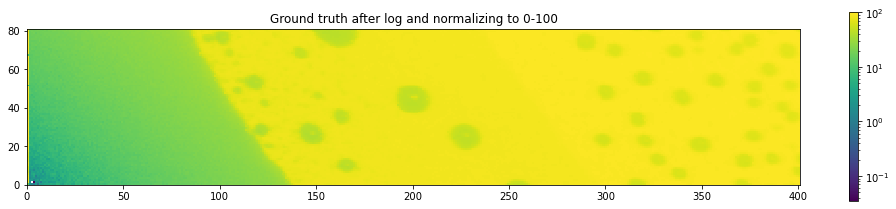

In [255]:
fig, axs = plt.subplots(1, 1, figsize=[14, 3])
plt.subplot(1,1,1)
plt.pcolormesh(log_int, cmap=cm, norm=cnorm())
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('Ground truth after log and normalizing to 0-100')
plt.tight_layout()

In [256]:
params_erd = ERDInputParams(c_value=C_VALUE,
                            full_erd_recalculation_frequency=full_erd_recalculation_frequency,
                            affected_neighbors_window_min=affected_neighbors_window_min,
                            affected_neighbors_window_max=affected_neighbors_window_max)
params_gen = GeneralInputParams()

sample_params = SampleParams(image_shape=log_int.shape,
                             inner_batch_size=inner_batch_size,
                             initial_scan_points_num=initial_scan_points_num,
                             initial_scan_ratio=None,
                             stop_ratio=stop_ratio,
                             random_seed=11)


#measurement_interface = ExperimentMeasurementInterface()#'instructions.csv', num_initial_idxs= 2000)
#interface.perform_measurement(sample_params.initial_idxs)
measurement_interface = TransmissionSimulationMeasurementInterface(image=log_int)

In [257]:
sample = Sample(sample_params=sample_params,
                general_params=params_gen,
                erd_params=params_erd,
                measurement_interface=measurement_interface,
                erd_model=erd_model)
results = Result()

In [258]:
run_sampling(sample, results=results, results_frequency_step=1, results_frequency_percentage=0, 
             disable_progress_bar=False, debug=False, indices_to_actually_measure=50)

No more improvements expected. Stopping scan.


(<sladsnet.code.results.Result at 0x179f93070>, 277)

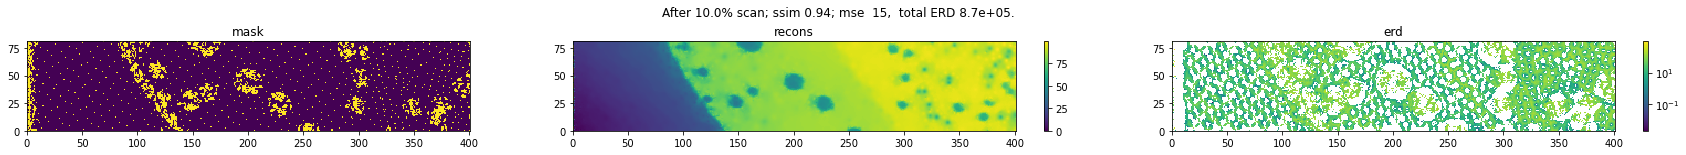

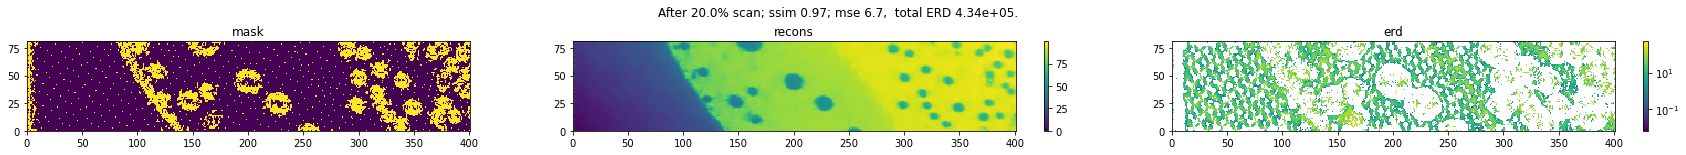

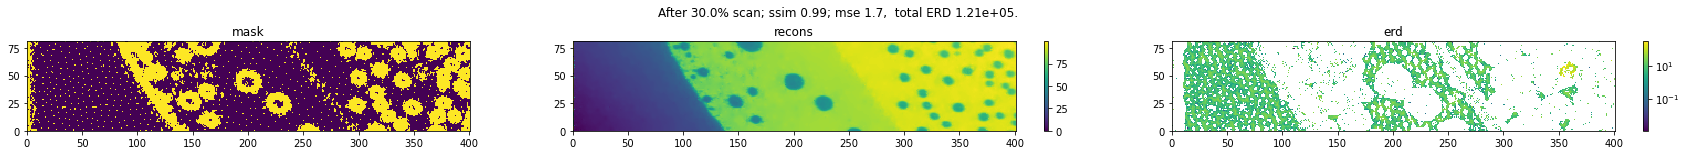

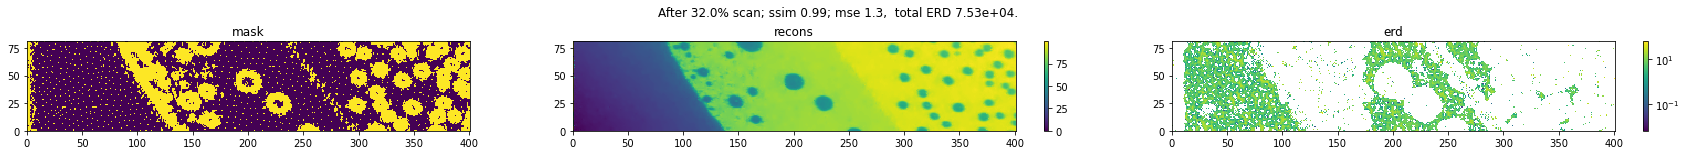

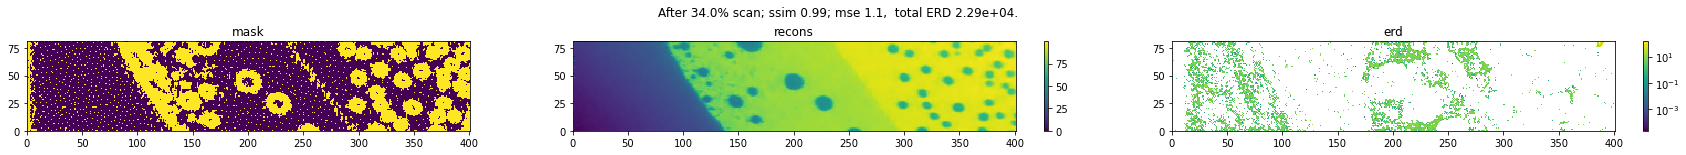

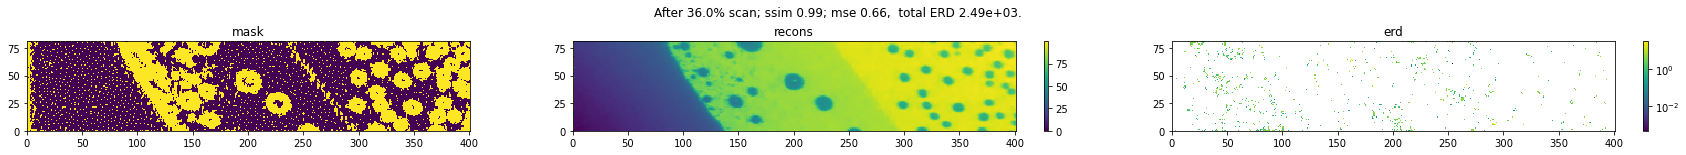

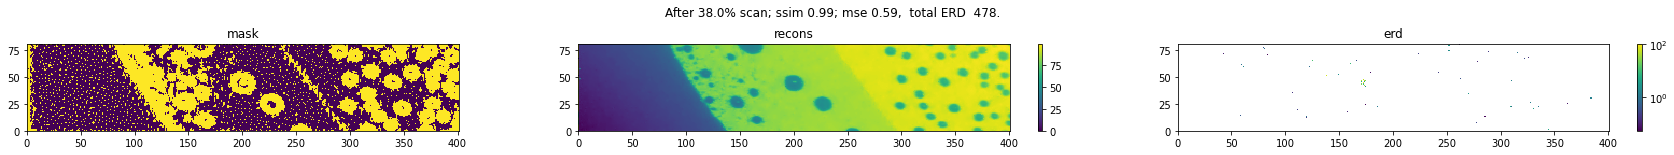

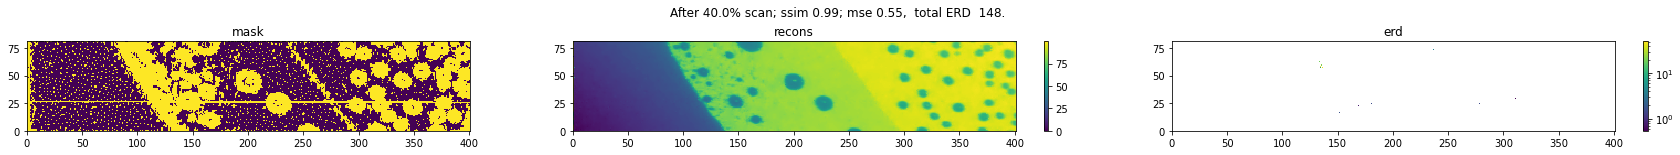

In [259]:
for i in range(results.size):
    #scan_ratio = (i + 1) * 0.1
    #percent = int(scan_ratio * 100)
    
    #if percent >= results.size:
    #    percent = results.size - 1
    
    actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 1)
    #percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
    percent = actual_percent
    if percent not in [10, 20, 30, 32, 34, 36, 37, 38, 39, 40, 50, 52, 53]: continue
    
    
    fig, axs = plt.subplots(1, 3, figsize=[25, 2])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[i])
    plt.gca().set_aspect('equal')
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[i], cmap=cm)
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    #err = measurement_interface.image - results.outputs.recons[i]
    plt.pcolormesh(results.outputs.erds[i], cmap=cm, norm=cnorm())#measurement_interface.image - results.outputs.recons[i])
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('erd')
    
    ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
    erd_this = results.outputs.erds[i].sum()
    
    plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
                 f' total ERD {erd_this:4.3g}.')
    plt.tight_layout()
    plt.show()


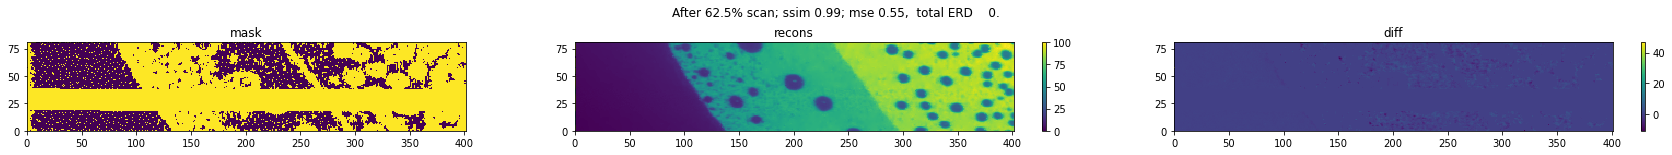

In [226]:
for i in range(results.size):
    #scan_ratio = (i + 1) * 0.1
    #percent = int(scan_ratio * 100)
    
    #if percent >= results.size:
    #    percent = results.size - 1
    
    actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 1)
    #percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
    percent = actual_percent
    if percent not in [51]: continue
    
    
    fig, axs = plt.subplots(1, 3, figsize=[25, 2])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[i])
    plt.gca().set_aspect('equal')
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[i], cmap=cm)
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    err = measurement_interface.image - results.outputs.recons[i]
    plt.pcolormesh(measurement_interface.image - results.outputs.recons[i])
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('diff')
    
    ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
    erd_this = results.outputs.erds[i].sum()
    
    plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
                 f' total ERD {erd_this:4.3g}.')
    plt.tight_layout()
    plt.show()


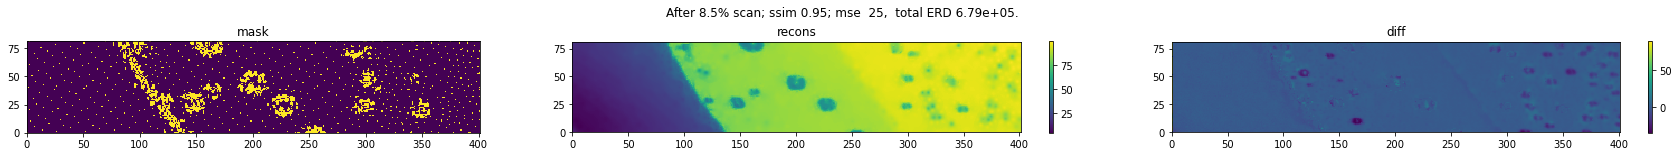

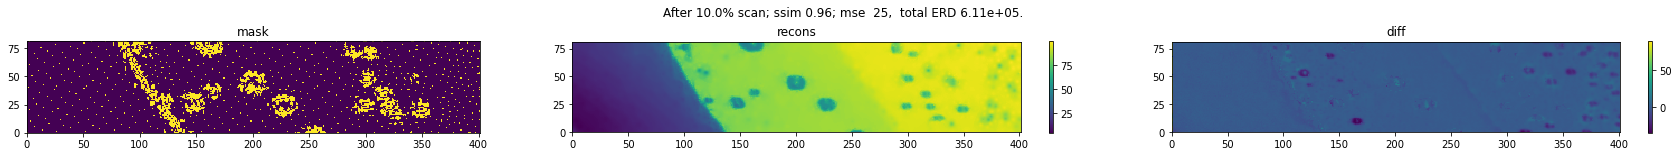

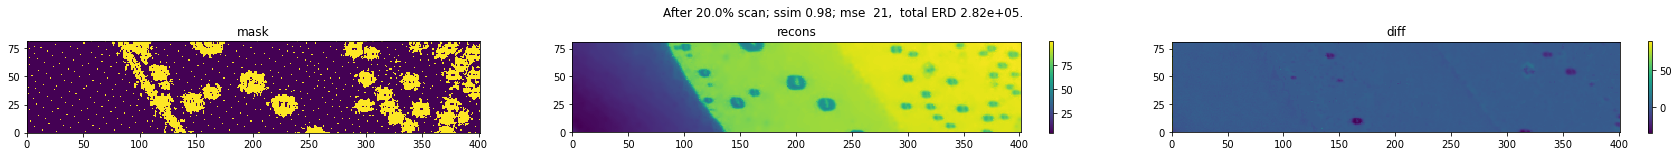

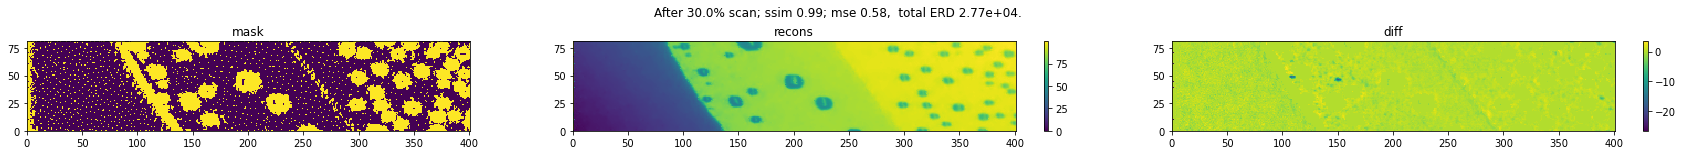

In [189]:
for i in range(results.size):
    #scan_ratio = (i + 1) * 0.1
    #percent = int(scan_ratio * 100)
    
    #if percent >= results.size:
    #    percent = results.size - 1
    
    actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 1)
    #percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
    percent = actual_percent
    #print(actual_percent)
    if percent not in [8.5, 10, 20, 30]: continue
    
    
    fig, axs = plt.subplots(1, 3, figsize=[25, 2])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[i])
    plt.gca().set_aspect('equal')
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[i], cmap=cm)
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    err = measurement_interface.image - results.outputs.recons[i]
    plt.pcolormesh(measurement_interface.image - results.outputs.recons[i])
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('diff')
    
    ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
    erd_this = results.outputs.erds[i].sum()
    
    plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
                 f' total ERD {erd_this:4.3g}.')
    plt.tight_layout()
    plt.show()


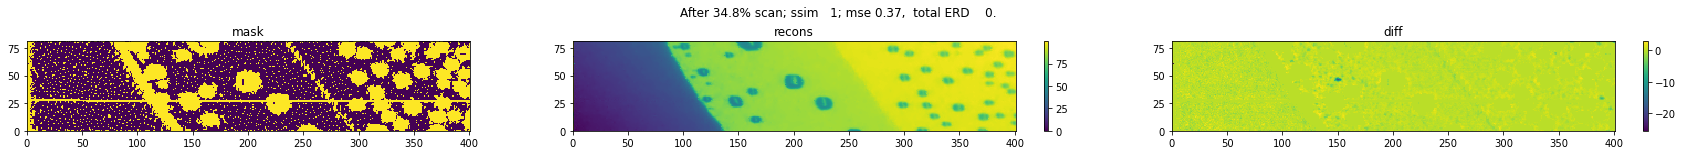

In [190]:
i = -1
actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 1)
#percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
percent = actual_percent
#if percent not in [10, 20, 30]: continue


fig, axs = plt.subplots(1, 3, figsize=[25, 2])
plt.subplot(1, 3, 1)
plt.pcolormesh(results.outputs.masks[i])
plt.gca().set_aspect('equal')
plt.title('mask')
plt.subplot(1, 3, 2)
plt.pcolormesh(results.outputs.recons[i], cmap=cm)
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('recons')
plt.subplot(1, 3, 3)
err = measurement_interface.image - results.outputs.recons[i]
plt.pcolormesh(measurement_interface.image - results.outputs.recons[i])
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('diff')

ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                             data_range=255)
mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
erd_this = results.outputs.erds[i].sum()

plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
             f' total ERD {erd_this:4.3g}.')
plt.tight_layout()
plt.show()

In [150]:
erds = results.outputs.erds
total_erds = np.sum(erds, axis=(1,2))

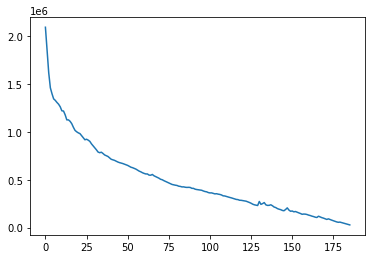

In [151]:
plt.plot(total_erds)

In [152]:
total_erds

array([2092872.1  , 1848517.   , 1618398.4  , 1460204.9  , 1398000.8  ,
       1344608.9  , 1328728.8  , 1307195.8  , 1288911.8  , 1261819.2  ,
       1219512.8  , 1217727.2  , 1177884.8  , 1125155.1  , 1125185.8  ,
       1110162.6  , 1085396.6  , 1047697.8  , 1015195.94 , 1000587.1  ,
        989379.2  ,  981457.06 ,  959502.3  ,  937022.56 ,  917285.75 ,
        922795.3  ,  913401.1  ,  900453.5  ,  874425.6  ,  854273.6  ,
        834531.4  ,  812336.4  ,  788980.6  ,  781996.5  ,  787204.5  ,
        773801.4  ,  758632.7  ,  750650.6  ,  742843.6  ,  727958.1  ,
        713387.9  ,  707338.25 ,  702159.56 ,  693742.44 ,  685003.56 ,
        678635.06 ,  673775.6  ,  669001.8  ,  662620.3  ,  655394.5  ,
        649391.44 ,  639291.   ,  630285.5  ,  625396.2  ,  617998.3  ,
        610741.5  ,  599519.1  ,  589540.94 ,  582228.56 ,  572756.25 ,
        565722.   ,  560096.7  ,  560075.44 ,  547945.9  ,  547025.06 ,
        554646.1  ,  540824.9  ,  532400.5  ,  523664.94 ,  5158

## Running for mda[2].d[6]

In [153]:
int1 = np.array(mda[2].d[6].data)

In [154]:
normalized_int = renormalize(int1)

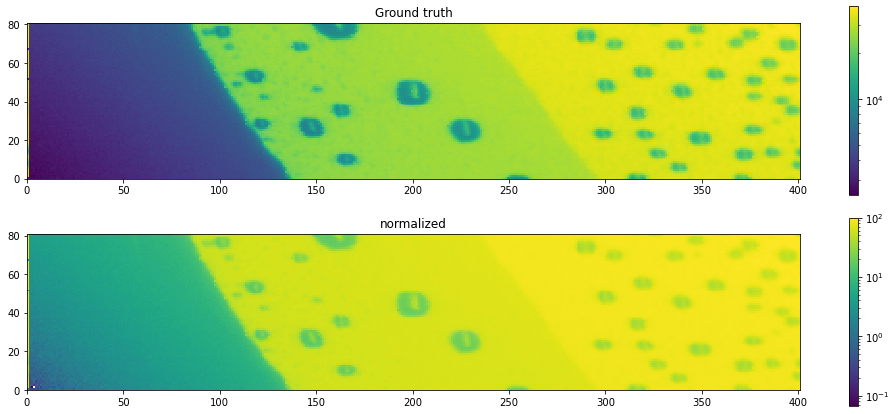

In [156]:
fig, axs = plt.subplots(2, 1, figsize=[14,6])
plt.subplot(2,1,1)
plt.pcolormesh(int1, cmap=cm, norm=cnorm())
plt.gca().set_aspect('equal')
plt.title('Ground truth')
plt.colorbar()
plt.subplot(2,1,2)
plt.pcolormesh(normalized_int, cmap=cm, norm=cnorm())
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('normalized')
plt.tight_layout()


In [157]:
inner_batch_size = 100
initial_scan_points_num = 500

stop_ratio = 0.3
store_results_percentage = 1

affected_neighbors_window_min = 5
affected_neighbors_window_max = 15
full_erd_recalculation_frequency = 1

In [158]:
params_erd = ERDInputParams(c_value=C_VALUE,
                            full_erd_recalculation_frequency=full_erd_recalculation_frequency,
                            affected_neighbors_window_min=affected_neighbors_window_min,
                            affected_neighbors_window_max=affected_neighbors_window_max)
params_gen = GeneralInputParams()

sample_params = SampleParams(image_shape=normalized_int.shape,
                             inner_batch_size=inner_batch_size,
                             initial_scan_points_num=initial_scan_points_num,
                             initial_scan_ratio=None,
                             stop_ratio=stop_ratio,
                             random_seed=11)


#measurement_interface = ExperimentMeasurementInterface()#'instructions.csv', num_initial_idxs= 2000)
#interface.perform_measurement(sample_params.initial_idxs)
measurement_interface = TransmissionSimulationMeasurementInterface(image=normalized_int)

In [159]:
sample = Sample(sample_params=sample_params,
                general_params=params_gen,
                erd_params=params_erd,
                measurement_interface=measurement_interface,
                erd_model=erd_model)
results = Result()

In [160]:
run_sampling(sample, results=results, results_frequency_step=1, results_frequency_percentage=0, 
             disable_progress_bar=False, debug=False, indices_to_actually_measure=50)

Reached the stopping ratio set in the sample parameters. Stopping scan.


(<sladsnet.code.results.Result at 0x179aff5e0>, 185)

In [161]:
erds = results.outputs.erds
total_erds = np.sum(erds, axis=(1,2))

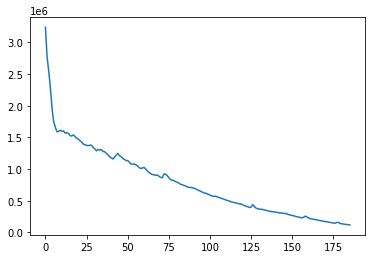

In [162]:
plt.plot(total_erds)

In [163]:
total_erds

array([3238912.5  , 2775510.   , 2549027.5  , 2291101.2  , 1963850.2  ,
       1749108.6  , 1662846.5  , 1588873.1  , 1595147.8  , 1611624.4  ,
       1598212.2  , 1602185.4  , 1567925.5  , 1574326.   , 1563051.1  ,
       1527059.6  , 1522333.4  , 1539494.8  , 1513300.   , 1484164.   ,
       1473035.6  , 1447312.8  , 1428448.8  , 1395092.6  , 1383844.   ,
       1375056.1  , 1369811.1  , 1376652.6  , 1375728.1  , 1343830.5  ,
       1319143.8  , 1288270.6  , 1309977.8  , 1298303.8  , 1309997.5  ,
       1277947.1  , 1274273.   , 1248530.2  , 1226659.1  , 1192726.2  ,
       1179902.9  , 1159487.   , 1186393.8  , 1215926.   , 1248100.1  ,
       1210814.8  , 1196859.5  , 1167984.4  , 1152756.2  , 1134609.5  ,
       1134480.2  , 1108687.5  , 1078478.   , 1080306.9  , 1078182.8  ,
       1068134.9  , 1051446.4  , 1022680.1  , 1009186.6  , 1017416.   ,
       1025690.5  ,  998156.   ,  970260.9  ,  947103.5  ,  927396.44 ,
        914713.   ,  910508.   ,  900739.1  ,  908559.5  ,  8870

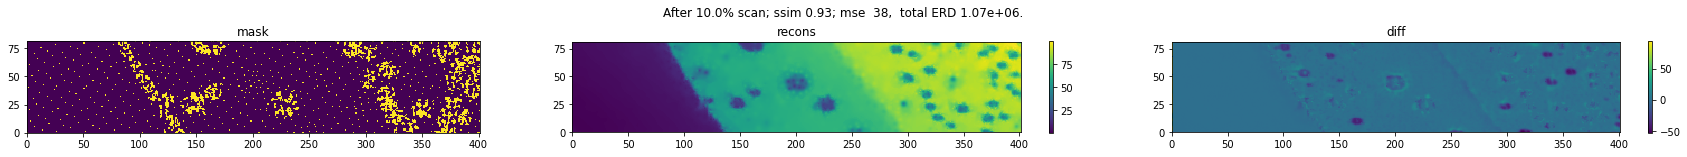

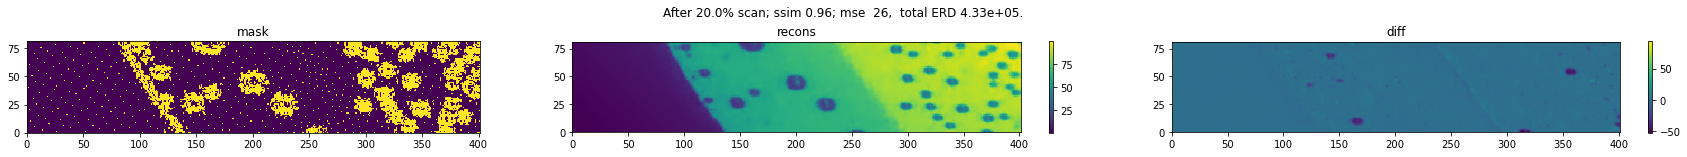

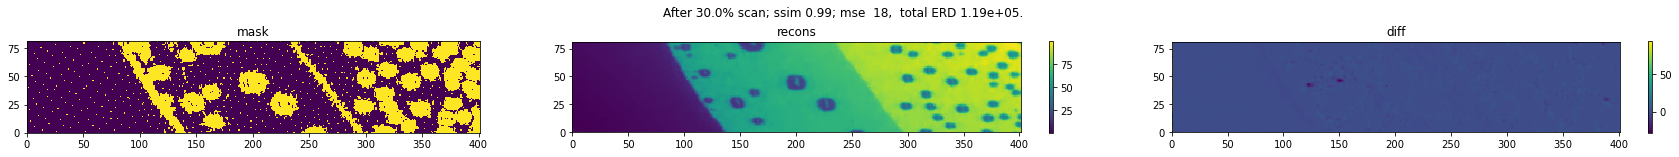

In [164]:
for i in range(results.size):
    #scan_ratio = (i + 1) * 0.1
    #percent = int(scan_ratio * 100)
    
    #if percent >= results.size:
    #    percent = results.size - 1
    
    actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 1)
    #percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
    percent = actual_percent
    if percent not in [10, 20, 30]: continue
    
    
    fig, axs = plt.subplots(1, 3, figsize=[25, 2])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[i])
    plt.gca().set_aspect('equal')
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[i], cmap=cm)
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    err = measurement_interface.image - results.outputs.recons[i]
    plt.pcolormesh(measurement_interface.image - results.outputs.recons[i])
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('diff')
    
    ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
    erd_this = results.outputs.erds[i].sum()
    
    plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
                 f' total ERD {erd_this:4.3g}.')
    plt.tight_layout()
    plt.show()


### Running the scan on the log 

In [165]:

log_int = renormalize(clean_and_normalize(np.log(int1)))

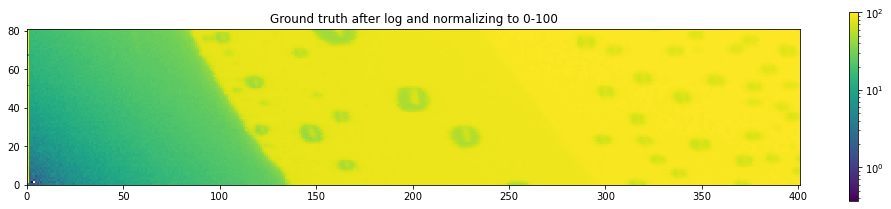

In [166]:
fig, axs = plt.subplots(1, 1, figsize=[14, 3])
plt.subplot(1,1,1)
plt.pcolormesh(log_int, cmap=cm, norm=cnorm())
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('Ground truth after log and normalizing to 0-100')
plt.tight_layout()

In [167]:
params_erd = ERDInputParams(c_value=C_VALUE,
                            full_erd_recalculation_frequency=full_erd_recalculation_frequency,
                            affected_neighbors_window_min=affected_neighbors_window_min,
                            affected_neighbors_window_max=affected_neighbors_window_max)
params_gen = GeneralInputParams()

sample_params = SampleParams(image_shape=log_int.shape,
                             inner_batch_size=inner_batch_size,
                             initial_scan_points_num=initial_scan_points_num,
                             initial_scan_ratio=None,
                             stop_ratio=stop_ratio,
                             random_seed=11)


#measurement_interface = ExperimentMeasurementInterface()#'instructions.csv', num_initial_idxs= 2000)
#interface.perform_measurement(sample_params.initial_idxs)
measurement_interface = TransmissionSimulationMeasurementInterface(image=log_int)

In [168]:
sample = Sample(sample_params=sample_params,
                general_params=params_gen,
                erd_params=params_erd,
                measurement_interface=measurement_interface,
                erd_model=erd_model)
results = Result()

In [169]:
run_sampling(sample, results=results, results_frequency_step=1, results_frequency_percentage=0, 
             disable_progress_bar=False, debug=False, indices_to_actually_measure=50)

Reached the stopping ratio set in the sample parameters. Stopping scan.


(<sladsnet.code.results.Result at 0x16bdbf6d0>, 185)

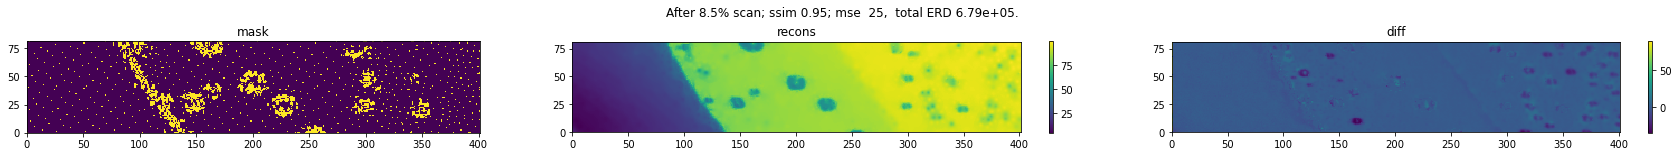

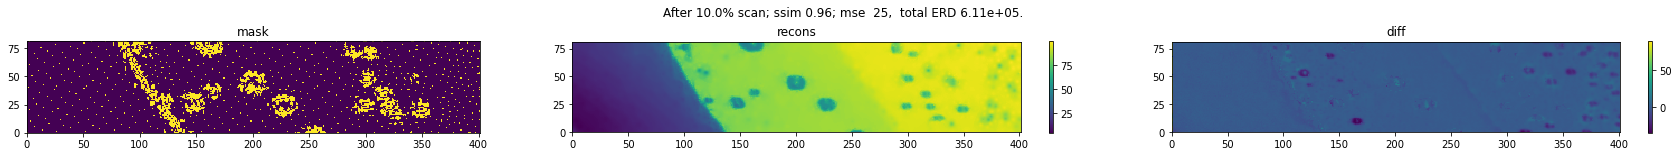

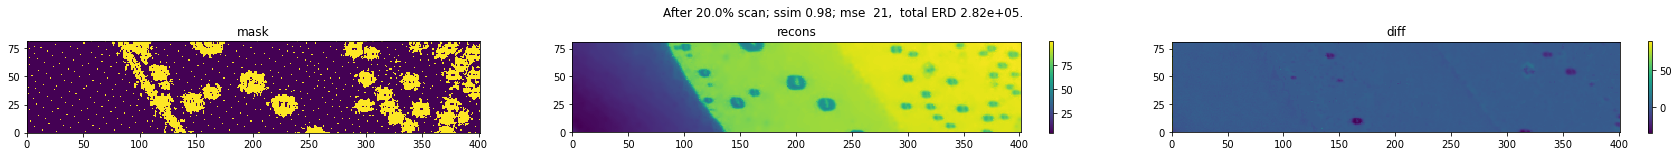

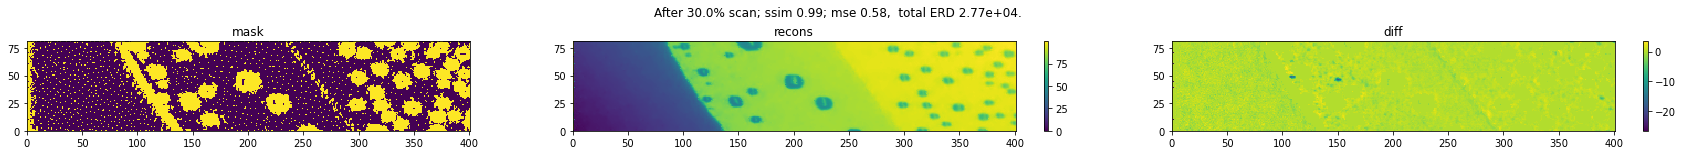

In [170]:
for i in range(results.size):
    #scan_ratio = (i + 1) * 0.1
    #percent = int(scan_ratio * 100)
    
    #if percent >= results.size:
    #    percent = results.size - 1
    
    actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 1)
    #percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
    percent = actual_percent
    #print(actual_percent)
    if percent not in [8.5, 10, 20, 30]: continue
    
    
    fig, axs = plt.subplots(1, 3, figsize=[25, 2])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[i])
    plt.gca().set_aspect('equal')
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[i], cmap=cm)
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    err = measurement_interface.image - results.outputs.recons[i]
    plt.pcolormesh(measurement_interface.image - results.outputs.recons[i])
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('diff')
    
    ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
    erd_this = results.outputs.erds[i].sum()
    
    plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
                 f' total ERD {erd_this:4.3g}.')
    plt.tight_layout()
    plt.show()


In [171]:
erds = results.outputs.erds
total_erds = np.sum(erds, axis=(1,2))

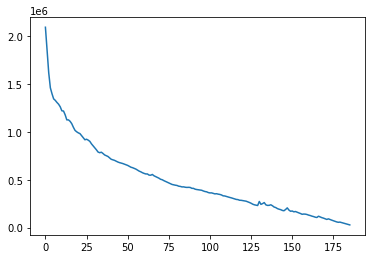

In [172]:
plt.plot(total_erds)

In [173]:
total_erds

array([2092872.1  , 1848517.   , 1618398.4  , 1460204.9  , 1398000.8  ,
       1344608.9  , 1328728.8  , 1307195.8  , 1288911.8  , 1261819.2  ,
       1219512.8  , 1217727.2  , 1177884.8  , 1125155.1  , 1125185.8  ,
       1110162.6  , 1085396.6  , 1047697.8  , 1015195.94 , 1000587.1  ,
        989379.2  ,  981457.06 ,  959502.3  ,  937022.56 ,  917285.75 ,
        922795.3  ,  913401.1  ,  900453.5  ,  874425.6  ,  854273.6  ,
        834531.4  ,  812336.4  ,  788980.6  ,  781996.5  ,  787204.5  ,
        773801.4  ,  758632.7  ,  750650.6  ,  742843.6  ,  727958.1  ,
        713387.9  ,  707338.25 ,  702159.56 ,  693742.44 ,  685003.56 ,
        678635.06 ,  673775.6  ,  669001.8  ,  662620.3  ,  655394.5  ,
        649391.44 ,  639291.   ,  630285.5  ,  625396.2  ,  617998.3  ,
        610741.5  ,  599519.1  ,  589540.94 ,  582228.56 ,  572756.25 ,
        565722.   ,  560096.7  ,  560075.44 ,  547945.9  ,  547025.06 ,
        554646.1  ,  540824.9  ,  532400.5  ,  523664.94 ,  5158